## DeepAR Model - Predict Bike Rental  

Note: This dataset is not a true timeseries as there a lot of gaps

We have data only for first 20 days of each month and model needs to predict the rentals for 
the remaining days of the month. The dataset consists of two years data. DeepAR will shine with true multiple-timeseries dataset like the electricity example given below

In [93]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import datetime


# This code is derived from AWS SageMaker Samples:
# https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/deepar_electricity
# https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/deepar_synthetic

In [94]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [146]:
# Provide endpoint
with_categories = False
endpoint_name = 'AAPL-no-categories-2020-12-30-23-42-14-622'

# Set datetime column as index to work with data based on Date/Time
df = pd.read_csv('AAPL_resampled.csv',parse_dates=[0], index_col=0)

In [147]:
freq='D' # Timeseries consists Hourly Data and we need to predict hourly rental count

# how far in the future predictions can be made
# 12 days worth of hourly forecast 
prediction_length = 5

# aws recommends setting context same as prediction length as a starting point. 
# This controls how far in the past the network can see
context_length = 15

mn=df.index.min()
mx=df.index.max()
mn,mx

(Timestamp('2019-12-23 00:00:00'), Timestamp('2020-12-22 00:00:00'))

In [148]:
dt_predict_max = pd.Timestamp(mx, freq=freq) # 2012-12-31 23:00 alt way..pd.datetime(2012,12,31,23,0,0)

dt_dataset_start_time = pd.Timestamp(mn, freq=freq)
dt_dataset_end_time = pd.Timestamp(mx, freq=freq)

# use for model training
# Start time is the first row provided by kaggle
# Training TS end time ensures some data is withheld for model testing
# 12 days worth of training data is withheld for testing
dt_train_range = (dt_dataset_start_time,
                  dt_dataset_end_time - datetime.timedelta(days=5) )

# Use entire data for testing
# We can compare predicted values vs actual (i.e. last 12 days is withheld for testing and model hasn't seen that data)
dt_test_range = (dt_dataset_start_time, 
                 dt_dataset_end_time) 

In [149]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

In [150]:
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]  

def encode_dynamic_feat(dynamic_feat):  
    l = []
    for col in dynamic_feat:
        assert (not dynamic_feat[col].isna().any()), col  + ' has NaN'             
        l.append(dynamic_feat[col].tolist())
    return l

def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = encode_dynamic_feat(dynamic_feat)
    return obj

def series_to_jsonline(ts, cat=None, dynamic_feat=None):
    return json.dumps(series_to_obj(ts, cat, dynamic_feat))      

In [151]:
# SDK 2. RealTimePredictor renamed to Predictor
class DeepARPredictor(sagemaker.predictor.Predictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        #prediction_times = [x.index[-1]+1 for x in ts]
        prediction_times = [x.index[-1] + datetime.timedelta(days=1) for x in ts] 
        
        req = self.__encode_request(ts, cat, dynamic_feat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, dynamic_feat, encoding, num_samples, quantiles):
        
        instances = [series_to_obj(ts[k], 
                                   cat[k] if cat else None,
                                   dynamic_feat if dynamic_feat else None) 
                     for k in range(len(ts))]
        
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            #prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            prediction_index = pd.date_range(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [152]:
# SDK 2 parameter name endpoint_name, content_type is specified as part of the serializer
predictor = DeepARPredictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session
)

predictor.set_prediction_parameters(freq, prediction_length)
predictor.serializer.content_type = "application/json"

In [153]:
df = pd.read_csv('all_data.csv', parse_dates=['datetime'],index_col=0)
df_test = pd.read_csv('AAPLtest.csv', parse_dates=['datetime'],index_col=0) # data points to be predicted for submission
df = df.resample('1D').mean()

In [154]:
df.tail()

,Close/Last,Volume,Open,High,Low
datetime,,,,,
2020-12-18,126.655,1.925415e+08,128.960,129.100,126.120
2020-12-19,125.525,2.116398e+08,126.985,127.724,123.610
2020-12-20,126.103,1.428517e+08,123.792,126.280,121.619
2020-12-21,128.230,1.212516e+08,125.020,128.310,123.449
2020-12-22,131.880,1.693518e+08,131.610,134.405,129.650


In [155]:
target_values = ['Close/Last']    #'['count','registered','casual']
time_series_test = []
time_series_training = []

for t in target_values:
    time_series_test.append(df[dt_test_range[0]:dt_test_range[1]][t])
    time_series_training.append(df[dt_train_range[0]:dt_train_range[1]][t])

In [156]:
time_series_training[0].tail(),time_series_test[0].tail()

(datetime
 2020-12-13    118.971
 2020-12-14    121.780
 2020-12-15    127.880
 2020-12-16    127.810
 2020-12-17    128.700
 Freq: D, Name: Close/Last, dtype: float64,
 datetime
 2020-12-18    126.655
 2020-12-19    125.525
 2020-12-20    126.103
 2020-12-21    128.230
 2020-12-22    131.880
 Freq: D, Name: Close/Last, dtype: float64)

In [157]:
# Provide 0 based index for categories
list_of_df = predictor.predict(time_series_training,
                               cat=[[0],[1],[2]] if with_categories else None)

In [158]:
for i in range(len(list_of_df)):
    print(len(list_of_df[i]))

5


In [159]:
list_of_df[0].head()

,0.1,0.9,0.5
2020-12-17 01:00:00,120.304794,129.957657,125.604294
2020-12-18 01:00:00,120.326279,128.588638,125.118065
2020-12-19 01:00:00,120.758911,130.421600,125.438950
2020-12-20 01:00:00,119.724075,131.296783,125.584450
2020-12-21 01:00:00,120.522987,128.520935,125.513527


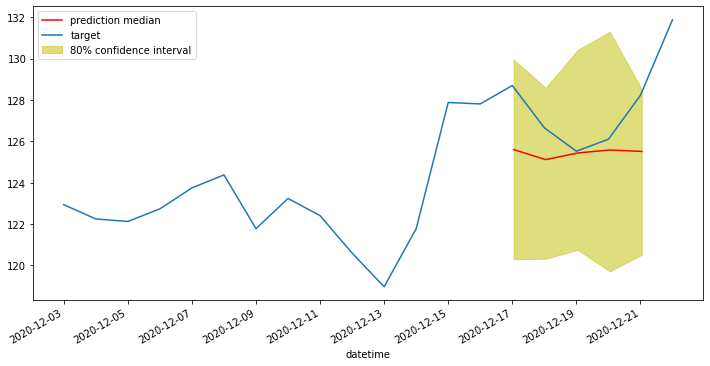

In [164]:
for k in range(len(list_of_df)):
    # print (-prediction_length-context_length) #120 = 72+48
    plt.figure(figsize=(12,6))
    list_of_df[k]['0.5'].plot(label='prediction median',color='r')
    time_series_test[k][-prediction_length-context_length:].plot(label='target')
    
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
   # list_of_df[k]['0.5'].plot(label='prediction median',color='r')
    plt.legend()
    plt.show()

In [165]:
predict_window = []

In [166]:
for i,x in df_test.groupby([df_test.index.year,df_test.index.month]):
    predict_window.append(x.index.min()-datetime.timedelta(hours=1))

In [167]:
predict_window

[Timestamp('2019-12-22 23:00:00'),
 Timestamp('2019-12-31 23:00:00'),
 Timestamp('2020-01-31 23:00:00'),
 Timestamp('2020-02-29 23:00:00'),
 Timestamp('2020-03-31 23:00:00'),
 Timestamp('2020-04-30 23:00:00'),
 Timestamp('2020-05-31 23:00:00'),
 Timestamp('2020-06-30 23:00:00'),
 Timestamp('2020-07-31 23:00:00'),
 Timestamp('2020-08-31 23:00:00'),
 Timestamp('2020-09-30 23:00:00'),
 Timestamp('2020-10-31 23:00:00'),
 Timestamp('2020-11-30 23:00:00')]

In [49]:
for t in target_values:
    df_test[t] = np.nan

In [50]:
df_test.head()

,Close/Last,Volume,Open,High,Low
datetime,,,,,
2019-12-23,NaN,9.871152e+07,70.132,71.062,70.093
2019-12-24,NaN,4.847884e+07,71.172,71.222,70.730
2019-12-25,NaN,5.266450e+07,71.033,71.694,70.877
2019-12-26,NaN,9.333600e+07,71.205,72.495,71.175
2019-12-27,NaN,1.463718e+08,72.780,73.492,72.030


In [51]:
for window in predict_window:
    print(window)
    # If trained with categories, we need to send corresponding category for each training set
    # In this case
    for i in range(len(target_values)):
        list_of_df = predictor.predict([time_series_test[i][:window]],
                                       cat=[i] if with_categories else None)
        df_tmp = list_of_df[0]
        df_tmp.index.name = 'datetime'
        df_tmp.columns = ['0.1',target_values[i],'0.9']
        df_test.update(df_tmp[target_values[i]])

2019-12-22 23:00:00


IndexError: index -1 is out of bounds for axis 0 with size 0

In [52]:
df_test.head()

,Close/Last,Volume,Open,High,Low
datetime,,,,,
2019-12-23,NaN,9.871152e+07,70.132,71.062,70.093
2019-12-24,NaN,4.847884e+07,71.172,71.222,70.730
2019-12-25,NaN,5.266450e+07,71.033,71.694,70.877
2019-12-26,NaN,9.333600e+07,71.205,72.495,71.175
2019-12-27,NaN,1.463718e+08,72.780,73.492,72.030


In [53]:
df_test.tail()

,Close/Last,Volume,Open,High,Low
datetime,,,,,
2020-12-18,NaN,1.925415e+08,128.960,129.100,126.120
2020-12-19,NaN,2.116398e+08,126.985,127.724,123.610
2020-12-20,NaN,1.428517e+08,123.792,126.280,121.619
2020-12-21,NaN,1.212516e+08,125.020,128.310,123.449
2020-12-22,NaN,1.693518e+08,131.610,134.405,129.650


In [54]:
def adjust_count(x):
    if x < 0:
        return 0
    else:
        return x

In [55]:
df_test['Close/Last'] = df_test['Close/Last'].map(adjust_count)

In [56]:
# Store the results
if with_categories:
    df_test[['Close/Last']].to_csv('prediction-with-categories.csv',index=True,index_label='datetime')
else:
    df_test[['Close/Last']].to_csv('prediction.csv',index=True,index_label='datetime')

In [57]:
# Delete the endpoint after completing the demo...otherwise, your account will accumulate hourly charges
predictor.delete_endpoint()

In [31]:
# Don't forget to terminate the end point after completing the demo
# Otherwise, you account will accumulate hourly charges

# you can delete from sagemaker management console or through command line or throught code

# predictor.delete_endpoint()